In [2]:
from google.colab import drive
drive.mount('/content/drive')
#подключаем гугл диск

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Домашнее задание №9.
1. Работа с изображением. Классификация изображений на примере размеченной и не размеченной выборки данных. Анализ используемых метрик для классификации изображения. 
2. Классификация текста на примере размеченной выборки данных. Анализ метрик классификации текста.<br>
Датасеты можно скачать по ссылке <br>
https://drive.google.com/open?id=1YRxK-ODyLiOYshw4lv01CyakheVqWJcu <br>
https://drive.google.com/open?id=1XQnV7LYkNdBtzqUrpIyh0wh2IdMqv7at <br>
https://drive.google.com/open?id=1xOXF078TAO1a6csCPCNCjJMtka3OSF6e <br>
(слишком они толстые что бы грузить их в домашнее задание). 

In [3]:
!pip install tqdm

In [4]:
%tensorflow_version 2.x

import io
import numpy as np
import os
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF,PCA
from sklearn.cluster import AgglomerativeClustering
import zipfile
from sklearn.metrics import silhouette_score,v_measure_score
import requests
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.manifold import TSNE
from tqdm import tqdm



TensorFlow 2.x selected.


In [0]:
from sklearn import svm
from pprint import pprint
from sklearn.model_selection import RandomizedSearchCV

In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

%matplotlib inline
from tqdm import tqdm_notebook
np.random.seed(500)
import warnings
from sklearn.utils.testing import ignore_warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
bow = CountVectorizer(ngram_range=(1,3))
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.svm import LinearSVC
import nltk





/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


##Работа с изображением.
Мы будем искать похожие картинки из имеющегося датасета. 

In [0]:
#файл на гугл диске. Распаковка
import zipfile
with zipfile.ZipFile('/content/drive/My Drive/diceimages.zip','r') as zfile:
    zfile.extractall('path')

In [0]:
#список файлов в папке 
base_dir = 'path'
img_dir = os.path.join(base_dir, 'dice-color/dice-color')
fnames = [os.path.join(img_dir, fname) for fname in os.listdir(img_dir)]

In [0]:
#уменьшение размерности файлов
fin=np.array([])
for img_path in fnames:
    img = image.load_img(img_path, target_size=(128,128))
    x = image.img_to_array(img)
    
    x = x.reshape(x.size)
    fin=np.append(fin,x)

In [0]:
fin=fin.reshape(len(fnames),-1)

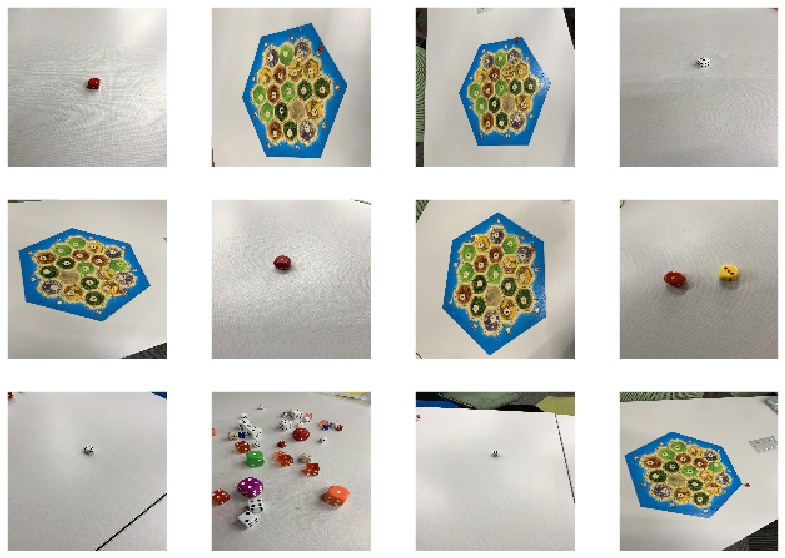

In [0]:
fig = plt.figure(figsize=(14, 10))

for i in range(12):
  
    f = fig.add_subplot(3, 4, i + 1) # 
    f.imshow(image.array_to_img(fin[i].reshape(128,128,3)),clip_on=True)
    plt.xticks([])
    plt.yticks([])


In [0]:
#применяем метрики уменьшения размерности
nmf = NMF(n_components=100).fit_transform(fin)
pca = PCA(n_components=100).fit_transform(fin)



In [0]:
#Поиск оптимального значения для метода k- средних. 
best_nmf=[0,0]
best_pca=[0,0]
for i in tqdm(range(2,25)):    
    preds_kmeans_nmf = KMeans(n_clusters=i).fit_predict(nmf)
    preds_kmeans_pca = KMeans(n_clusters=i).fit_predict(pca)
    score_kmeans_nmf = silhouette_score(nmf, preds_kmeans_nmf)
    score_kmeans_pca = silhouette_score(pca, preds_kmeans_pca)
    if score_kmeans_nmf>best_nmf[0]:
        best_nmf[0]=score_kmeans_nmf
        best_nmf[1]=i
    if score_kmeans_pca>best_pca[0]:
        best_pca[0]=score_kmeans_pca
        best_pca[1]=i
        
print('\nnmf  ',best_nmf)
print('pca  ',best_nmf)

100%|██████████| 23/23 [00:07<00:00,  2.28it/s]


nmf   [0.5926806854030169, 5]
pca   [0.5926806854030169, 5]


In [0]:
#Для AgglomerativeClustering
best_nmf=[0,0]
best_pca=[0,0]
for i in tqdm(range(2,25)):    
    preds_agg_nmf = AgglomerativeClustering(n_clusters=i).fit_predict(nmf)
    preds_agg_pca = AgglomerativeClustering(n_clusters=i).fit_predict(pca)
    score_agg_nmf = silhouette_score(nmf, preds_agg_nmf)
    score_agg_pca = silhouette_score(pca, preds_agg_pca)
    if score_agg_nmf>best_nmf[0]:
        best_nmf[0]=score_agg_nmf
        best_nmf[1]=i
    if score_agg_pca>best_pca[0]:
        best_pca[0]=score_agg_pca
        best_pca[1]=i
        
print('\nnmf  ',best_nmf)
print('pca  ',best_nmf)

100%|██████████| 23/23 [00:00<00:00, 31.92it/s]


nmf   [0.5876461206130076, 2]
pca   [0.5876461206130076, 2]


То есть для k-mean лучший результат при 5, для AgglomerativeClustering - при 2.

In [0]:
kmean=KMeans(n_clusters=2).fit_predict(pca)
#визуализируем для n=2

In [0]:
pca_tsne = TSNE(n_components=2).fit_transform(pca)

Text(0.5, 0, 't-SNE признак 1')

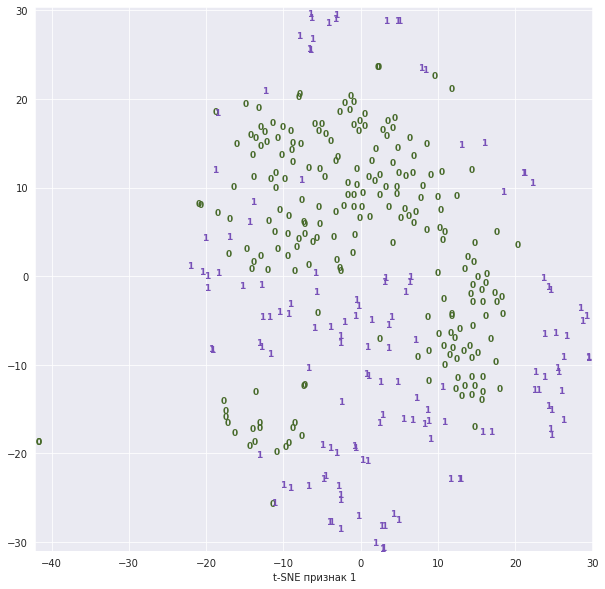

In [0]:
plt.figure(figsize=(10, 10))
colors = ["#476A2A", "#7851B8", "#BD3430","#4A2D4E", "#875525",
          "#A83683", "#4E655E"]
plt.xlim(pca_tsne[:, 0].min(), pca_tsne[:, 0].max() + 1)
plt.ylim(pca_tsne[:, 1].min(), pca_tsne[:, 1].max() + 1)
for i in range(len(pca_tsne)):
    # строим график, где цифры представлены символами вместо точек
    # в данном случае мы выделяем как они размечены. 
    plt.text(pca_tsne[i, 0], pca_tsne[i, 1], str(kmean[i]),
        color = colors[kmean[i]],
        fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("t-SNE признак 0")
plt.xlabel("t-SNE признак 1")

В целом мы конечно можем выделить отдельные сегменты.

In [0]:
#В данном тслучае мы обрабатываем 2-х мерное представление данных. Обработка данных после PCA не дает результат при либых n и eps
from sklearn.cluster import DBSCAN
for eps in [1, 3, 5, 7, 9, 11, 13]:
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=3)
    labels = dbscan.fit_predict(pca_tsne)
    print("Полученные кластеры: {}".format(np.unique(labels)))
    print("Размеры кластеров: {}".format(np.bincount(labels + 1)))


eps=1
Полученные кластеры: [-1  0  1  2  3  4  5  6  7  8  9]
Размеры кластеров: [328   3   3   4   3   3   3   3   3   3   3]

eps=3
Полученные кластеры: [-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Размеры кластеров: [ 25 232   7  12  36   6   8   7   3   3   3   3   6   3   5]

eps=5
Полученные кластеры: [-1  0  1  2]
Размеры кластеров: [  4 345   7   3]

eps=7
Полученные кластеры: [-1  0]
Размеры кластеров: [  2 357]

eps=9
Полученные кластеры: [-1  0]
Размеры кластеров: [  2 357]

eps=11
Полученные кластеры: [-1  0]
Размеры кластеров: [  2 357]

eps=13
Полученные кластеры: [-1  0]
Размеры кластеров: [  2 357]


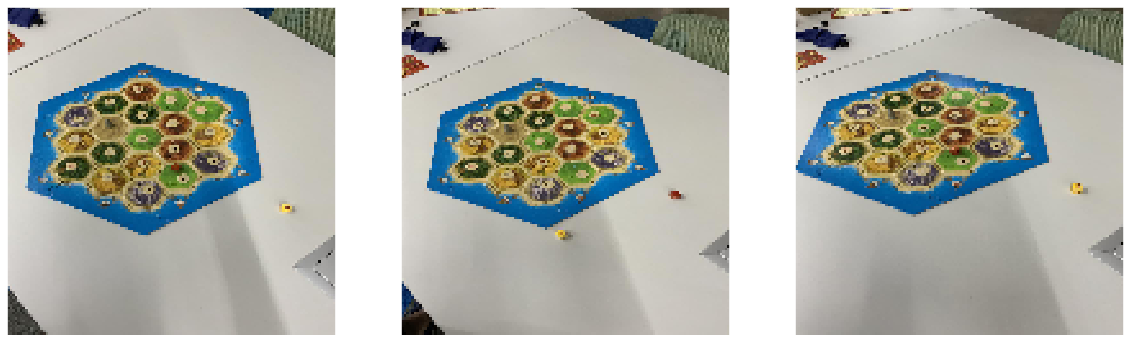

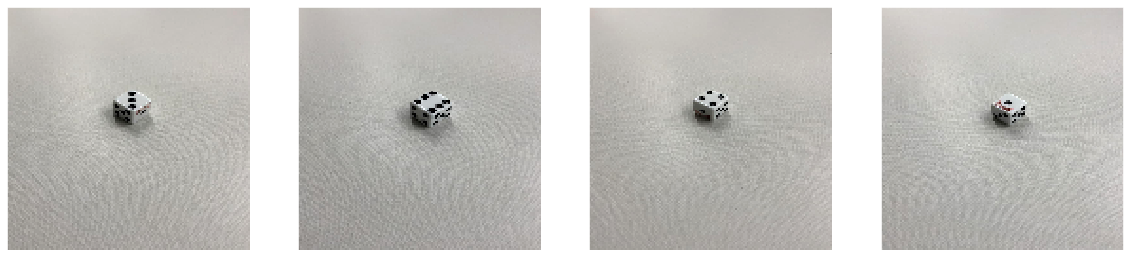

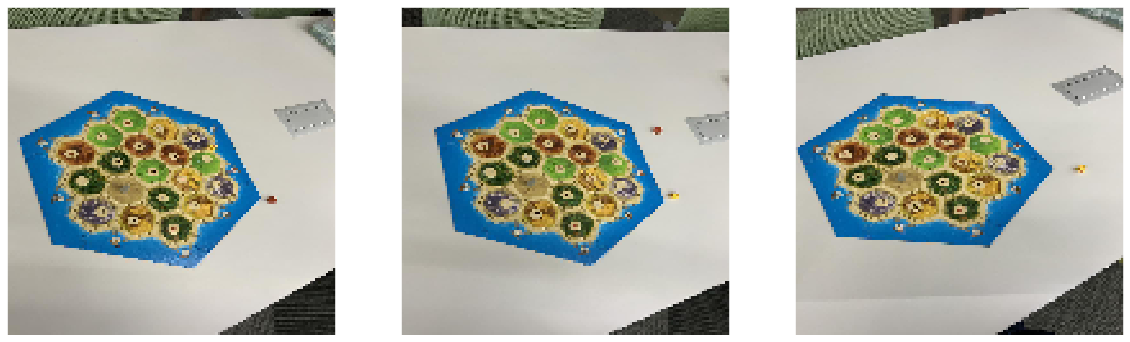

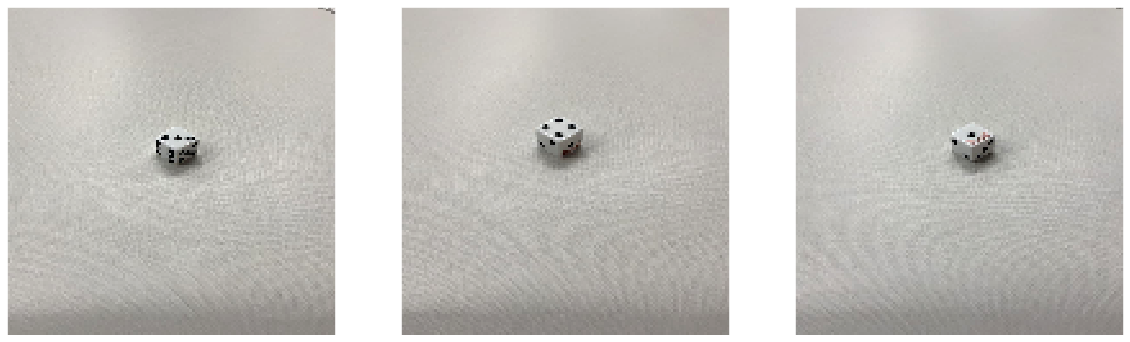

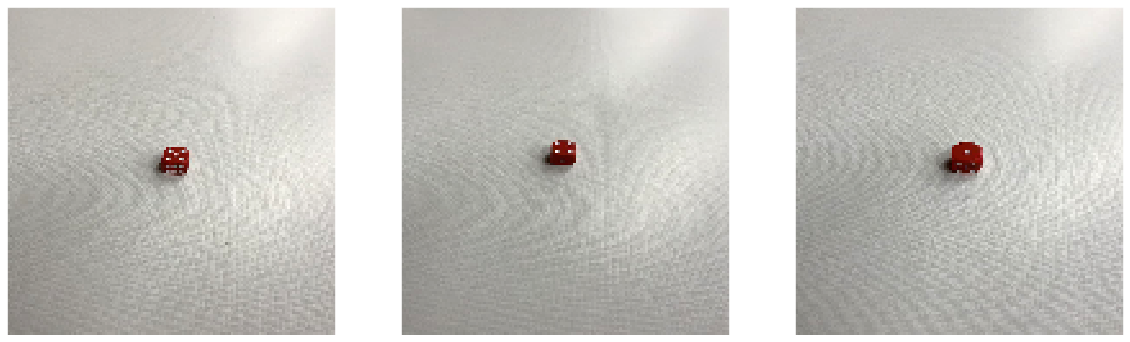

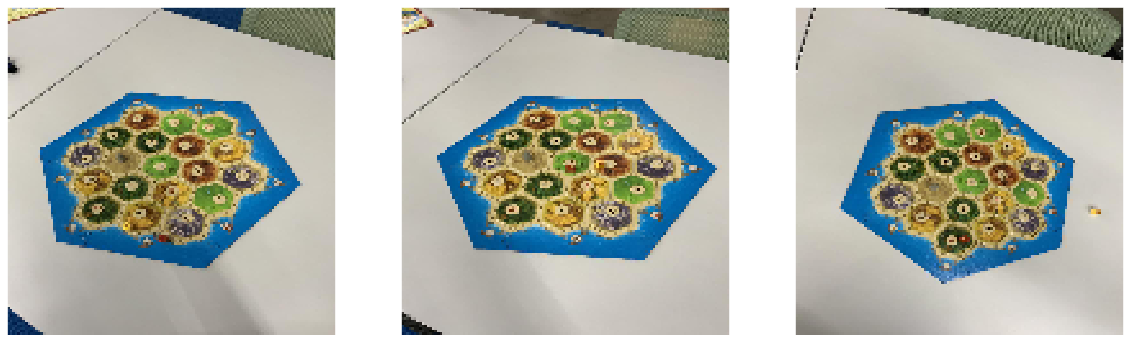

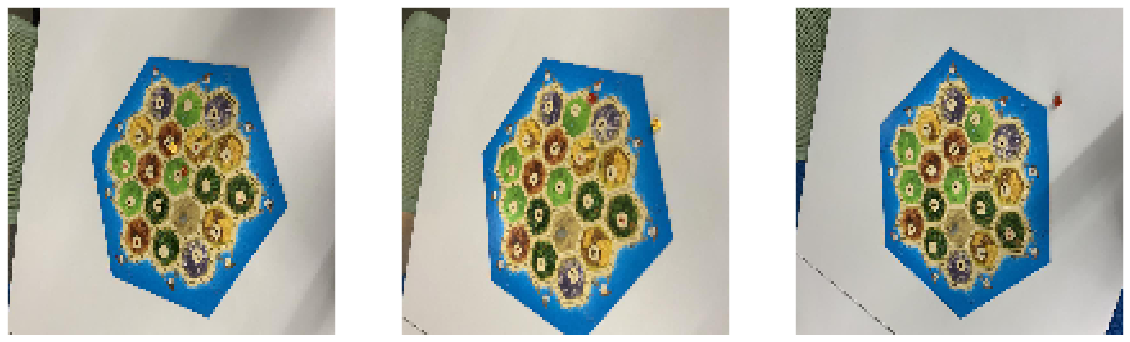

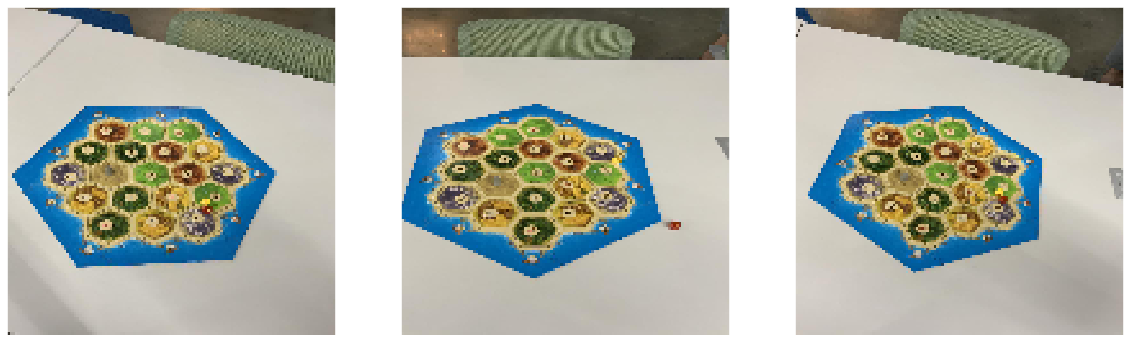

In [0]:
#визуализируем выделенные кластера
dbscan = DBSCAN(min_samples=3, eps=1)
labels = dbscan.fit_predict(pca_tsne)



for i in range(1,max(labels)):

    fig = plt.figure(figsize=(20, 10))  
    
    j=0
    s=[]
    for index, item in enumerate(labels):
      if item ==i:
        s.append(index)
        
    for k in range(0,len(labels[labels==i])):

     
      if len(labels[labels==i])==0:
        break
          

      f = fig.add_subplot(1, len(labels[labels==i]), k+1)  
      f.imshow(image.array_to_img(fin[s[k]].reshape(128,128,3)),clip_on=True);
      plt.xticks([])
      plt.yticks([])
      

Можно назвать данные картинки похожими. Однако что делать с "шумом"? Данный алгоритм подходит для поиска похожих объектов в большом наборе данных весьма условно. Оценку качества нужно проводить визуально.  

---
Довольно сложно классифицировать по неразмечанным данным объекты. Зачастую базовые методы показывают низкий результат. Проклятие размерности не позволяет использовать методы подбора на больших объемах данных.

In [0]:
#в данном случае у нас имееться размечанный сет данных в котором основными картинками выступают геометрические фигуры. Для примера. 
import zipfile
with zipfile.ZipFile('/content/drive/My Drive/rectangle-ellipse-multimodal.zip','r') as zfile:
    zfile.extractall('rectangle')

In [0]:
base_dir = 'rectangle'
img_dir = os.path.join(base_dir, 'rectangle_ellipse_multimodal/train')
fnames = [os.path.join(img_dir, fname) for fname in os.listdir(img_dir)]

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
test_datagen = ImageDataGenerator(rescale=1./255)

In [0]:
train_generator = test_datagen.flow_from_directory(
        img_dir,
        target_size=(50, 50),
        batch_size = 1)

Found 45000 images belonging to 3 classes.


In [0]:
train_feat=[]
val_lbl=[]

for i in range(len(train_generator)):
        train_feat.append(train_generator[i][0].flatten())
        val_lbl.append(train_generator[i]) 
#мы выделяем собсивенно саму картинку и переводим ее в одномерный массив.        

In [0]:
res=np.array([],dtype=np.int8)
for i in range(len(val_lbl)):
    res = np.append(res,np.argmax(val_lbl[i][1]))

In [0]:
res
#мы выделяем класс к которому относиться картинка

array([0, 1, 0, ..., 2, 2, 1])

In [0]:
pca = PCA(n_components=100).fit_transform(train_feat) #уменьшаем размерность

In [0]:
kmeans = KMeans(n_clusters=6).fit_predict(pca)
print('silhouette_score n=6  ',silhouette_score(pca, kmeans))
print('v_measure_score n=6  ',v_measure_score(res, kmeans))
#путем перебора выяснено что силуэт максимальный при n=6

silhouette_score n=6   0.4600483109822325
v_measure_score n=6   0.3489517228800621


In [0]:
kmeans = KMeans(n_clusters=3).fit_predict(pca)
print('silhouette_score n=3  ',silhouette_score(pca, kmeans))
print('v_measure_score n=3  ',v_measure_score(res, kmeans))
#в данном случае мы смотрим на размечанный сет для n=3 (число классов)

silhouette_score n=3   0.41646544956431686
v_measure_score n=3   0.12255124799879036


In [0]:
digits_tsne = TSNE(n_components=2).fit_transform(pca)

Text(0.5, 0, 't-SNE признак 1')

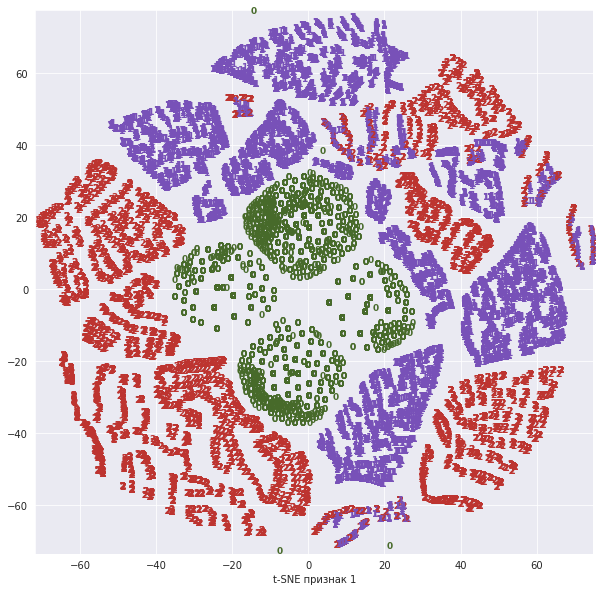

In [0]:
plt.figure(figsize=(10, 10))
colors = ["#476A2A", "#7851B8", "#BD3430","#4A2D4E", "#875525",
          "#A83683", "#4E655E"]
plt.xlim(digits_tsne[:, 0].min(), digits_tsne[:, 0].max() + 1)
plt.ylim(digits_tsne[:, 1].min(), digits_tsne[:, 1].max() + 1)
for i in range(len(digits_tsne)):
    # строим график, где цифры представлены символами вместо точек
    # в данном случае мы выделяем как они размечены. 
    plt.text(digits_tsne[i, 0], digits_tsne[i, 1], str(res[i]),
        color = colors[res[i]],
        fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("t-SNE признак 0")
plt.xlabel("t-SNE признак 1")

Text(0.5, 0, 't-SNE признак 1')

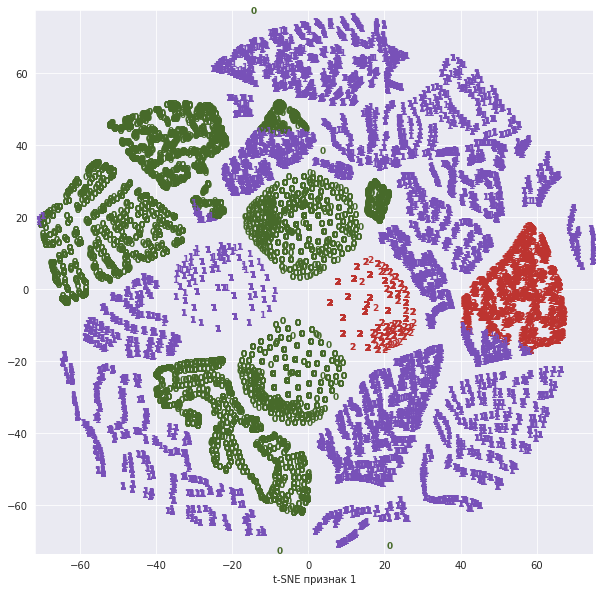

In [0]:
plt.figure(figsize=(10, 10))
colors = ["#476A2A", "#7851B8", "#BD3430","#4A2D4E", "#875525",
          "#A83683", "#4E655E"]
plt.xlim(digits_tsne[:, 0].min(), digits_tsne[:, 0].max() + 1)
plt.ylim(digits_tsne[:, 1].min(), digits_tsne[:, 1].max() + 1)
for i in range(len(digits_tsne)):
    # строим график, где цифры представлены символами вместо точек
    plt.text(digits_tsne[i, 0], digits_tsne[i, 1], str(kmeans[i]),
        color = colors[kmeans[i]],
        fontdict={'weight': 'bold', 'size': 9})
plt.xlabel("t-SNE признак 0")
plt.xlabel("t-SNE признак 1")

В данном случае мы знаем, что у нас 3 класса. Посмотрим на результат визуализации всего этого.

In [0]:
kmeans = KMeans(n_clusters=6).fit_predict(pca)
#для 6 классов

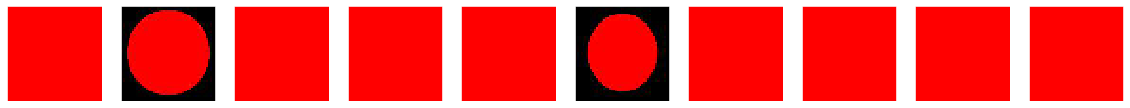

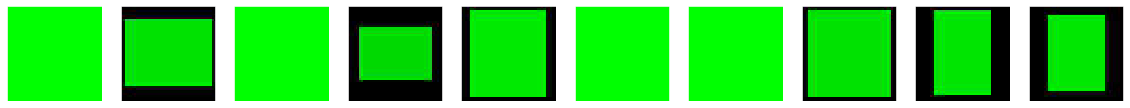

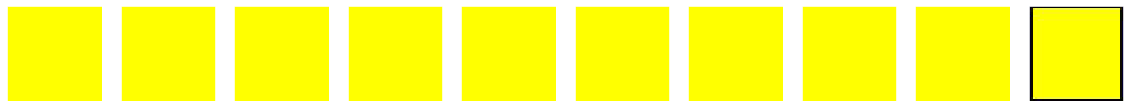

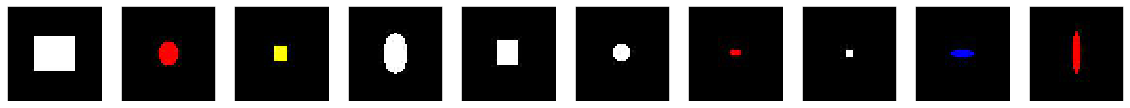

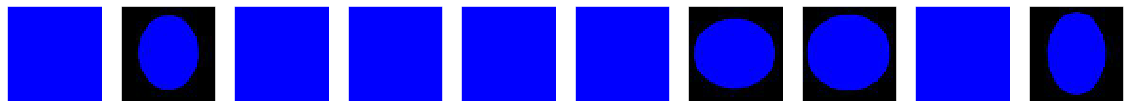

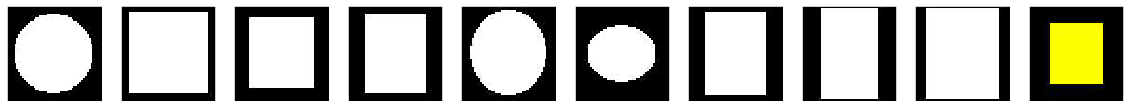

In [0]:
for i in range(0,max(kmeans)+1):

    s=[]
    for index, item in enumerate(kmeans):
      if item ==i:
        s.append(index)

    fig = plt.figure(figsize=(20, 10))  
    
    j=0
    
    for k in range(0,10):
              
      #print(len(labels[labels==i]))
      f = fig.add_subplot(1, 10, k+1)  
      f.imshow(image.array_to_img(train_feat[s[k]].reshape(50,50,3)),clip_on=True);
      plt.xticks([])
      plt.yticks([])
      

In [0]:
kmeans = KMeans(n_clusters=12).fit_predict(pca)
#для 12 классов

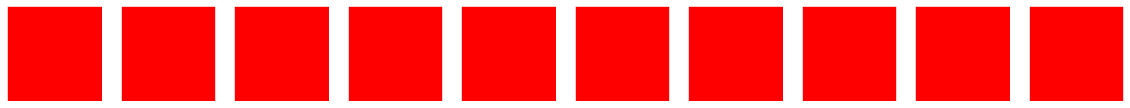

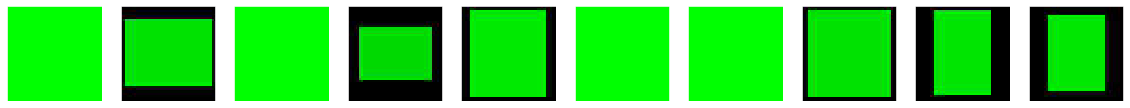

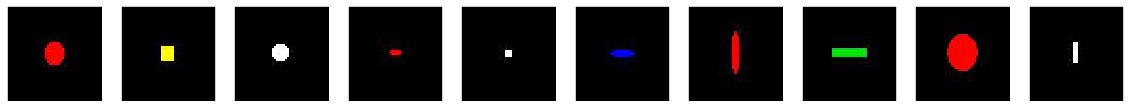

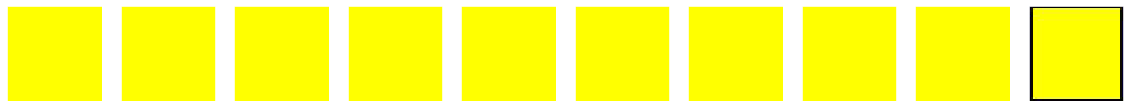

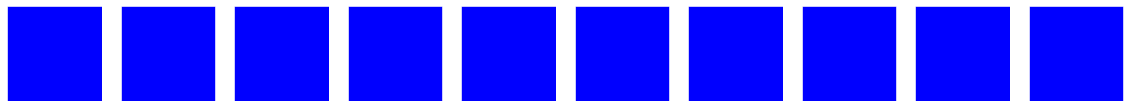

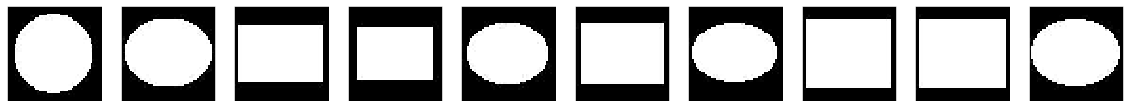

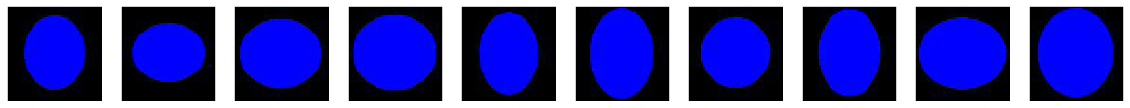

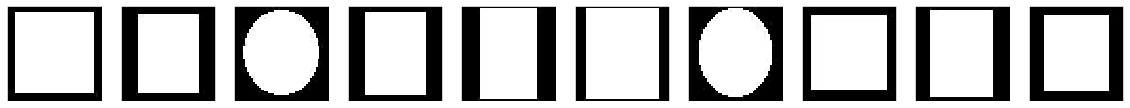

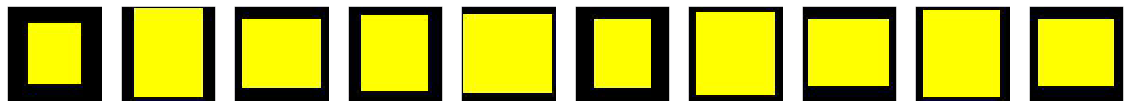

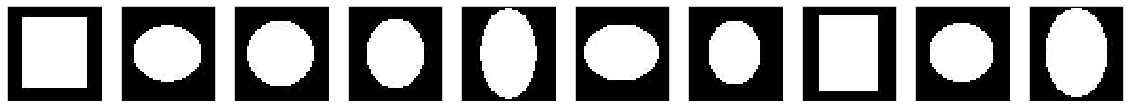

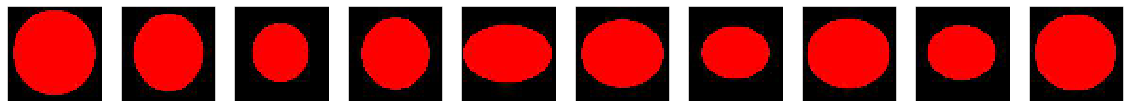

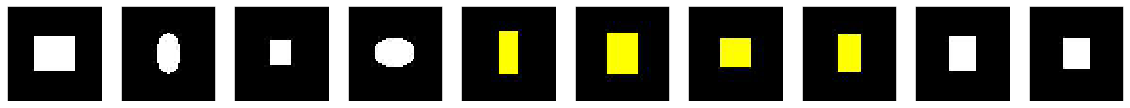

In [0]:
for i in range(0,max(kmeans)+1):

    s=[]
    for index, item in enumerate(kmeans):
      if item ==i:
        s.append(index)

    fig = plt.figure(figsize=(20, 10))  
    
    j=0
    
    for k in range(0,10):
              
      #print(len(labels[labels==i]))
      f = fig.add_subplot(1, 10, k+1)  
      f.imshow(image.array_to_img(train_feat[s[k]].reshape(50,50,3)),clip_on=True);
      plt.xticks([])
      plt.yticks([])

Тут и 12 класстеров дает неплохой результат. 

In [0]:
from sklearn import metrics
inertia = []
for k in tqdm(range(2, 37)):
    km = KMeans(n_clusters=k, random_state=1,init='k-means++',n_init=3).fit(pca)
    count=[]   
    count.append(metrics.homogeneity_score(res, km.labels_))
    count.append(metrics.completeness_score(res, km.labels_))
    count.append(metrics.v_measure_score(res, km.labels_))
    count.append(metrics.adjusted_rand_score(res, km.labels_))
    count.append(metrics.silhouette_score(pca, km.labels_, sample_size=1000))
    inertia.append(count)

100%|██████████| 35/35 [01:06<00:00,  2.96s/it]


In [0]:
inertia=np.array(inertia)

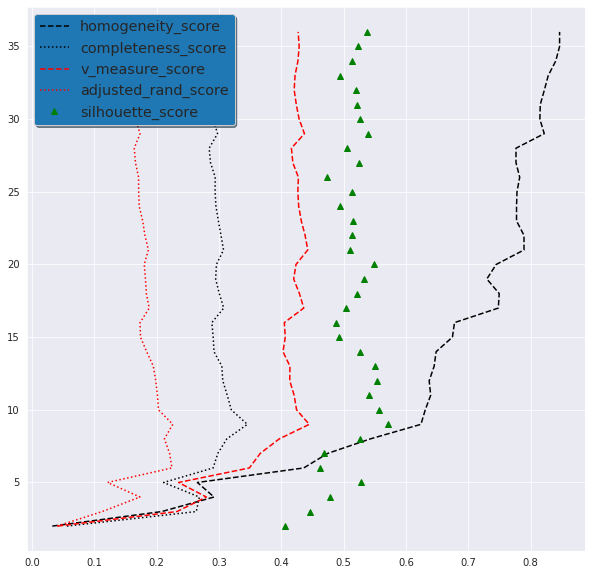

In [0]:
c=range(2,37)
fig, ax = plt.subplots()
fig.set_size_inches(10, 10, forward=True) 
ax.plot(inertia[:, 0], c, 'k--', label='homogeneity_score')
ax.plot(inertia[:, 1], c, 'k:', label='completeness_score')
ax.plot(inertia[:, 2], c, 'r--', label='v_measure_score')
ax.plot(inertia[:, 3], c, 'r:', label='adjusted_rand_score')
ax.plot(inertia[:, 4], c, 'g^', label='silhouette_score')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')

legend.get_frame().set_facecolor('C0')
plt.show()


В данном случае можно предположить что тут 6-12 классов. Хотя в размеченной выборки их только 3.

##Выводы:
Класисфикация изображений очень субьективна. Даже простых. Не имея четко размеченной срустуры очень сложно сделать вывод по имеющимся метрикам. 



##Классификация текста
В данном примере взят текст с [kaggle](https://www.kaggle.com/ramkrboss/news-category-dataset). 
Мы не будем использовать сами статьи так как это очень большая размерность. В качестве текста с которым мы будем работать будет использоваться название статьи ее краткое описание.

In [7]:
df = pd.read_json('/content/drive/My Drive/DZ_9/News_Category_Dataset_v2.json', lines=True)
df.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [8]:
df.info()
#смотрим на колонки

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 6 columns):
category             200853 non-null object
headline             200853 non-null object
authors              200853 non-null object
link                 200853 non-null object
short_description    200853 non-null object
date                 200853 non-null datetime64[ns]
dtypes: datetime64[ns](1), object(5)
memory usage: 9.2+ MB


In [9]:
df.category.value_counts()
#сами классы

POLITICS          32739
WELLNESS          17827
ENTERTAINMENT     16058
TRAVEL             9887
STYLE & BEAUTY     9649
PARENTING          8677
HEALTHY LIVING     6694
QUEER VOICES       6314
FOOD & DRINK       6226
BUSINESS           5937
COMEDY             5175
SPORTS             4884
BLACK VOICES       4528
HOME & LIVING      4195
PARENTS            3955
THE WORLDPOST      3664
WEDDINGS           3651
WOMEN              3490
IMPACT             3459
DIVORCE            3426
CRIME              3405
MEDIA              2815
WEIRD NEWS         2670
GREEN              2622
WORLDPOST          2579
RELIGION           2556
STYLE              2254
SCIENCE            2178
WORLD NEWS         2177
TASTE              2096
TECH               2082
MONEY              1707
ARTS               1509
FIFTY              1401
GOOD NEWS          1398
ARTS & CULTURE     1339
ENVIRONMENT        1323
COLLEGE            1144
LATINO VOICES      1129
CULTURE & ARTS     1030
EDUCATION          1004
Name: category, 

In [0]:
df.category = df.category.map(lambda x: "WORLDPOST" if x == "THE WORLDPOST" else x)
df.category = df.category.map(lambda x: "STYLE" if x == "STYLE & BEAUTY" else x)
df.category = df.category.map(lambda x: "ARTS" if x == "CULTURE & ARTS" or x == "ARTS & CULTURE"  else x)
#объединям классы которые похожи по названию.

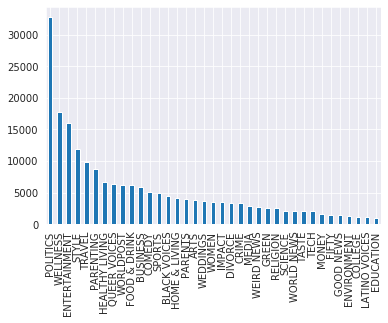

In [11]:
df.category.value_counts().plot(kind='bar');

In [0]:
df['text'] = df.headline + " " + df.short_description
 

In [0]:
#удаляем все лишнее
import re
df.text = df.text.apply(lambda x: re.sub(r'[^\w\s]',' ',x))
df.text = df.text.apply(lambda x: re.sub(r'[\d]','',x))

In [14]:
df.head()

,category,headline,authors,link,short_description,date,text
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,There Were Mass Shootings In Texas Last Week ...
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,Will Smith Joins Diplo And Nicky Jam For The ...
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,Hugh Grant Marries For The First Time At Age ...
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,Jim Carrey Blasts Castrato Adam Schiff And D...
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,Julianna Margulies Uses Donald Trump Poop Bags...


In [15]:
#импортируем и удаляем стоп слова
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
df.text  = df.text.apply(lambda x: ' '.join(x for x in x.split() if x not in stop_words))

In [0]:
new_df_RNN=df.copy() #создаем локально неочищенную копию для RNN сети.

In [19]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [0]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

In [0]:
df.text  = df.text.apply(lambda x: ' '.join(lemmatizer.lemmatize(x) for x in x.split()))#леммитизируем

In [0]:
df.text =df.text.apply(lambda x: str.lower(x)) #приводим текст к 1 регистру

In [23]:
df.text

0         there were mass shootings in texas last week b...
1         will smith joins diplo and nicky jam for the w...
2         hugh grant marries for the first time at age t...
3         jim carrey blasts castrato adam schiff and dem...
4         julianna margulies uses donald trump poop bags...
                                ...                        
200848    rim ceo thorsten heins significant plans for b...
200849    maria sharapova stunned by victoria azarenka i...
200850    giants over patriots jets over colts among mos...
200851    aldon smith arrested er linebacker busted for ...
200852    dwight howard rips teammates after magic loss ...
Name: text, Length: 200853, dtype: object

In [0]:
counts = pd.Series(''.join(df.text).split()).value_counts()

In [25]:
counts #считаем число слов. Стоит удалить наиболее часто встрачаемые слова

the               69042
i                 44932
to                40220
in                29940
a                 28973
                  ...  
designerdirty         1
intoxicatingly        1
bigguatemala          1
caseonly              1
suitability           1
Length: 254786, dtype: int64

In [26]:
high_freq = counts[:int(pd.Series(''.join(df.text).split()).count()*1/10000)]
high_freq

the         69042
i           44932
to          40220
in          29940
a           28973
            ...  
hair         1414
children     1412
recent       1411
single       1410
true         1410
Length: 401, dtype: int64

In [0]:
low_freq = counts[:-int(pd.Series(''.join(df.text).split()).count()*1/10000):-1]
#и наиболее редко встречаемые

In [0]:
low_freq

halloweentobacco    1
stylekids           1
beatingkanye        1
achievedin          1
substantialowen     1
                   ..
tellmike            1
tonightmarie        1
technologylast      1
catter              1
knowdesigning       1
Length: 400, dtype: int64

In [0]:
df.text  = df.text.apply(lambda x: ' '.join(x for x in x.split() if x not in low_freq)) #удаляем

In [0]:
df.text  = df.text.apply(lambda x: ' '.join(x for x in x.split() if x not in high_freq))

In [0]:
df.text

0         were mass shootings texas only left husband ki...
1         smith joins diplo nicky jam cup official song ...
2         hugh grant marries actor longtime girlfriend a...
3         jim carrey blasts castrato adam schiff democra...
4         julianna margulies uses poop bags pick dog die...
                                ...                        
200848    rim ceo thorsten heins significant plans black...
200849    maria sharapova stunned victoria azarenka aust...
200850    giants patriots jets colts among improbable su...
200851    aldon smith arrested er linebacker busted dui ...
200852    dwight howard rips teammates magic loss hornet...
Name: text, Length: 200853, dtype: object

In [0]:
categories = df.groupby('category').size().index.tolist()

In [0]:
len(categories)
#У нас задача многоклассовой классифкации с 37 категориями.

37

In [0]:
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence

In [0]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df.text)
X = tokenizer.texts_to_sequences(df.text)
df['words'] = X


In [0]:
from sklearn.preprocessing import LabelEncoder
li=LabelEncoder()
df['id_category']=li.fit_transform(df.category)




In [34]:
df['word_length'] = df.words.apply(lambda i: len(i))
df = df[df.word_length >= 3]
df.head()

,category,headline,authors,link,short_description,date,text,words,id_category,word_length
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26,were mass shootings texas only left husband ki...,"[597, 775, 4253, 227, 205, 30, 114, 123]",5,8
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26,smith joins diplo nicky jam cup official song ...,"[967, 3195, 21504, 22748, 3923, 927, 129, 328,...",8,10
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26,hugh grant marries actor longtime girlfriend a...,"[5174, 3469, 7067, 333, 4636, 1624, 2067, 5133...",8,12
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26,jim carrey blasts castrato adam schiff democra...,"[2138, 9824, 3513, 51336, 1767, 11446, 90, 540...",8,12
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26,julianna margulies uses poop bags pick dog die...,"[34669, 28153, 1734, 6688, 5298, 353, 10, 5133...",8,13


In [35]:
df.word_length.describe()

count    197984.000000
mean         12.138850
std           5.475614
min           3.000000
25%           8.000000
50%          12.000000
75%          15.000000
max         105.000000
Name: word_length, dtype: float64

In [0]:
df['new_text'] = df.text.apply(lambda i: i.split()) # картедж слов

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
vectorizer = TfidfVectorizer(stop_words='english',max_features=1000,ngram_range=(1,2)) #как бы не правильно брать 1000 но из за больших размерностей мы опустим этот момент

In [0]:
X = vectorizer.fit_transform(df.text)

In [40]:
print(X.shape)

(197984, 1000)


In [0]:
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD

In [0]:
svd = TruncatedSVD(n_components=10).fit_transform(X)

In [0]:
#слишком долго это будет работать.
best_svd=np.zeros(4,dtype=np.int8)
s=[]
for i in tqdm(range(2,40)):
  preds_kmeans_svd = KMeans(n_clusters=i).fit_predict(svd)
  score_kmeans_svd = silhouette_score(svd, preds_kmeans_svd)
  measure_kmeans_svd=v_measure_score(df.id_category,preds_kmeans_svd)
  s.append([i,score_kmeans_svd,measure_kmeans_svd])
  print(i,'   ',score_kmeans_svd)
  print(i,'   ',measure_kmeans_svd)
  if score_kmeans_svd>best_svd[0]:
        best_svd[0]=score_kmeans_svd
        best_svd[1]=i
  if measure_kmeans_svd>best_svd[2]:
        best_svd[2]=score_kmeans_svd
        best_svd[3]=i

Данный метод очень затратен по ресурсам и мало эффективен. 

In [0]:
s=np.array(s)

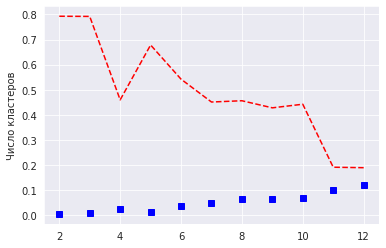

In [0]:
import matplotlib.pyplot as plt
plt.plot(s[:,0], s[:,1], 'r--', s[:,0], s[:,2], 'bs')
plt.ylabel('Значение метрики')
plt.xlabel('Число кластеров')
plt.show()

Мы видим, что silhouette_score являеться очень субьективной метриков в нашем случае.

In [0]:
preds_kmeans_svd = KMeans(n_clusters=37).fit_predict(svd)
measure_kmeans_svd=v_measure_score(df.id_category,preds_kmeans_svd)

In [0]:
measure_kmeans_svd #v_measure_score не лучше силуэта при n= числу класстеров

0.1308403275297496

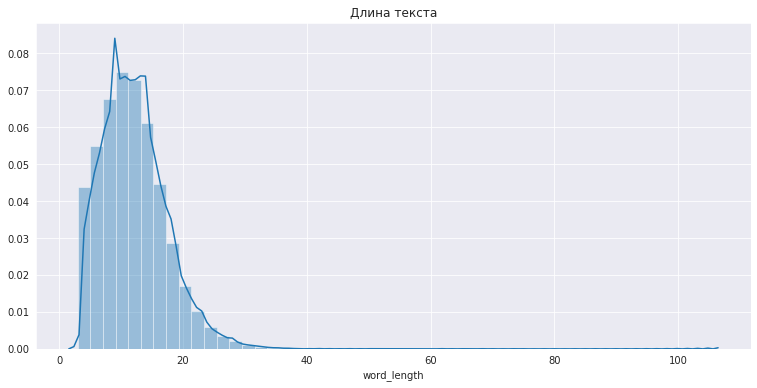

In [0]:
#число слов в нашем тексте. Видим хвост. В теории по нему можно обрезать наш текст. 
plt.figure(figsize=(12.8,6))
sns.distplot(df['word_length']).set_title('Длина текста');

In [0]:
#Например так.
quantile_95 = df['word_length'].quantile(0.95)
df_95 = df[df['News_length'] < quantile_95]

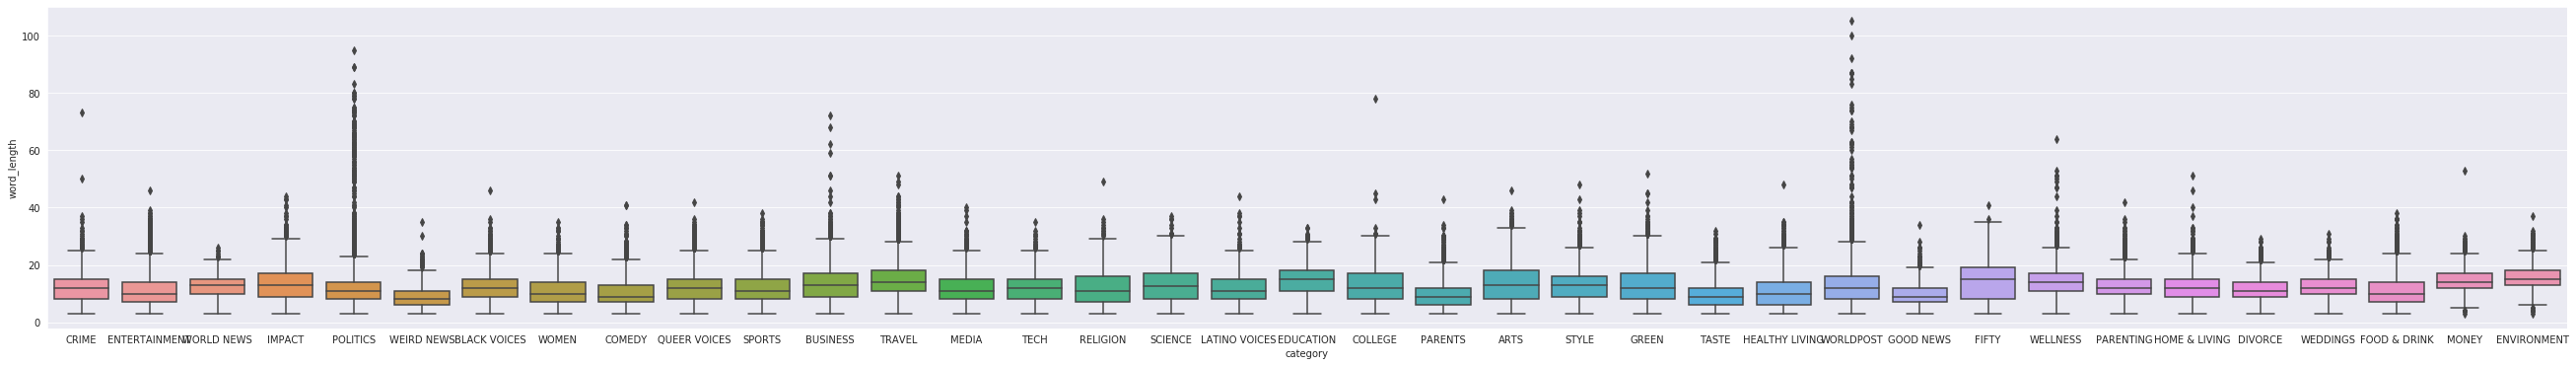

In [0]:
plt.figure(figsize=(45.8,6))
sns.boxplot(data=df, x='category', y='word_length');
#По идее хвосты нужно обрезать, но с другой стороны это потеря информации. 

In [0]:

X_train, X_test, y_train, y_test, id_train, id_test = train_test_split(X, df.id_category,df.index, test_size=0.95)#берем случайные 5%


In [0]:
tsne_tf_idf_train = TSNE(n_components=2).fit_transform(X_train)

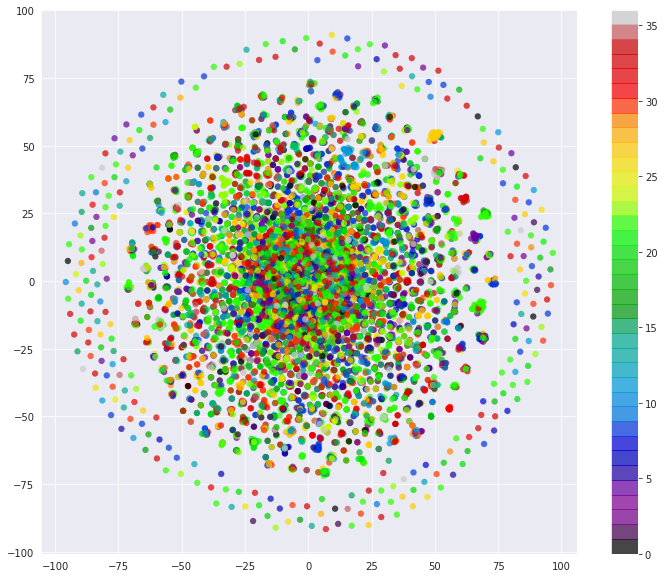

In [0]:
plt.figure(figsize=(12,10))
plt.scatter(tsne_tf_idf_train[:, 0], tsne_tf_idf_train[:, 1], c=y_train, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 37))
plt.colorbar()

In [0]:
#В данном тслучае мы обрабатываем 2-х мерное представление данных. Обработка данных после PCA не дает результат при либых n и eps
from sklearn.cluster import DBSCAN
for eps in [1, 3, 5, 7, 9, 11, 13]:
    print("\neps={}".format(eps))
    dbscan = DBSCAN(eps=eps, min_samples=2)
    labels = dbscan.fit_predict(tsne_tf_idf_train)
    print("Полученные кластеры: {}".format(np.unique(labels)))
    print("Размеры кластеров: {}".format(np.bincount(labels + 1)))


eps=1
Полученные кластеры: [  -1    0    1 ... 1181 1182 1183]
Размеры кластеров: [ 429 2292    9 ...    2    2    2]

eps=3
Полученные кластеры: [ -1   0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16
  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34
  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52
  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106
 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124
 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142
 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160
 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178
 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196
 197 198 199 200 201 202 203 204 205 206 207 208 2

In [0]:
from sklearn.cluster import DBSCAN
#визуализируем пару кластеров
dbscan = DBSCAN(min_samples=2, eps=3)
labels = dbscan.fit_predict(tsne_tf_idf_train)
     

In [0]:
for i,j in enumerate(labels):
     
      if j==170:
         print(df.text[id_train[i]])
   

dozens retired generals admirals iran nuclear dozen retired general admiral released letter tuesday supporting iran nuclear urging congress
iran nuclear gridlock technical iran nuclear present rare opportunity major diplomatic victory negotiator p iran bridge remaining gap resolve major security threat potential iranian nuclear weapon shot fired
iran decisions nuclear talks
nancy pelosi announces strong iran congress review nuclear agreement
saudi nuclear talks barometer whither middle east james m dorsey talks aimed transferring nuclear technology saudi arabia serve indicator


In [0]:
#сложно кластеризировать текст после обработки и леметизации как похожий с человеческой точки восприятия. 

In [0]:
from sklearn import metrics
inertia = []
for k in tqdm(range(2, 60)):
    count=[] 
    km = KMeans(n_clusters=k, random_state=1,init='k-means++',n_init=3).fit(X_train)
    #count.append(np.sqrt(kmeans.inertia_))
    
    count.append(metrics.homogeneity_score(y_train, km.labels_))
    count.append(metrics.completeness_score(y_train, km.labels_))
    count.append(metrics.v_measure_score(y_train, km.labels_))
    count.append(metrics.adjusted_rand_score(y_train, km.labels_))
    count.append(metrics.silhouette_score(X_train, km.labels_, sample_size=1000))
    inertia.append(count)

100%|██████████| 58/58 [03:18<00:00,  3.12s/it]


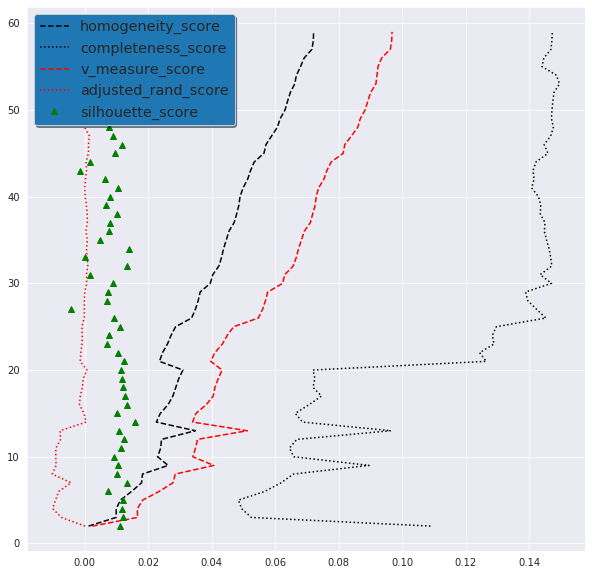

In [0]:
inertia=np.array(inertia)
c=range(2,60)
fig, ax = plt.subplots()
fig.set_size_inches(10, 10, forward=True) 
ax.plot(inertia[:, 0], c, 'k--', label='homogeneity_score')
ax.plot(inertia[:, 1], c, 'k:', label='completeness_score')
ax.plot(inertia[:, 2], c, 'r--', label='v_measure_score')
ax.plot(inertia[:, 3], c, 'r:', label='adjusted_rand_score')
ax.plot(inertia[:, 4], c, 'g^', label='silhouette_score')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C0')
plt.show()

Сложно по метрикам что либо вообще тут выделить по числу классов. Можно предположить что их тут порядка 20.

---
Предобработка данных. 

In [0]:
import tensorflow as tf
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df.text) 
text_sequences = tokenizer.texts_to_sequences(df.text)
text_sequences = tf.keras.preprocessing.sequence.pad_sequences(
text_sequences)
num_records = len(text_sequences)
max_seqlen = len(text_sequences[0])

---
Визуализация

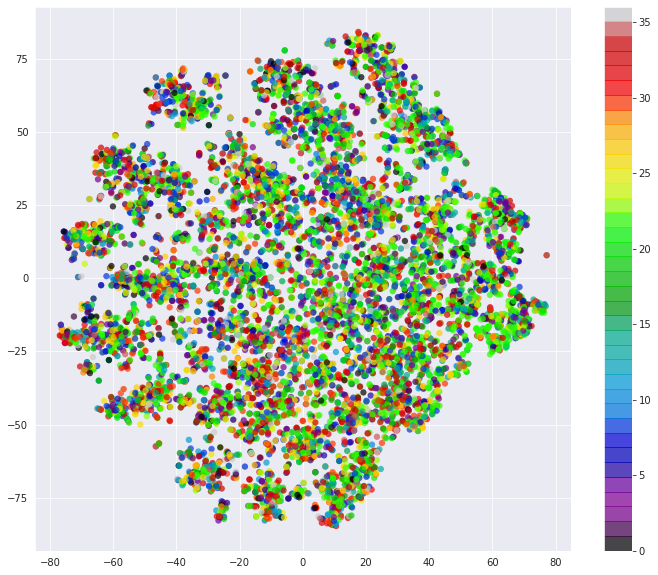

In [58]:
X_train,X_id_train, y_train, y_id_test = train_test_split(text_sequences,df.id_category, test_size=0.95)#берем случайные 5%
tsne_tf_idf_train = TSNE(n_components=2).fit_transform(X_train)
plt.figure(figsize=(12,10))
plt.scatter(tsne_tf_idf_train[:, 0], tsne_tf_idf_train[:, 1], c=y_train, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 37))
plt.colorbar()

In [59]:
from sklearn import metrics
inertia = []
for k in tqdm(range(2, 60)):
    count=[] 
    km = KMeans(n_clusters=k, random_state=1,init='k-means++',n_init=3).fit(tsne_tf_idf_train)
    #count.append(np.sqrt(kmeans.inertia_))
    
    count.append(metrics.homogeneity_score(y_train, km.labels_))
    count.append(metrics.completeness_score(y_train, km.labels_))
    count.append(metrics.v_measure_score(y_train, km.labels_))
    count.append(metrics.adjusted_rand_score(y_train, km.labels_))
    count.append(metrics.silhouette_score(X_train, km.labels_, sample_size=1000))
    inertia.append(count)

100%|██████████| 58/58 [00:21<00:00,  1.83it/s]


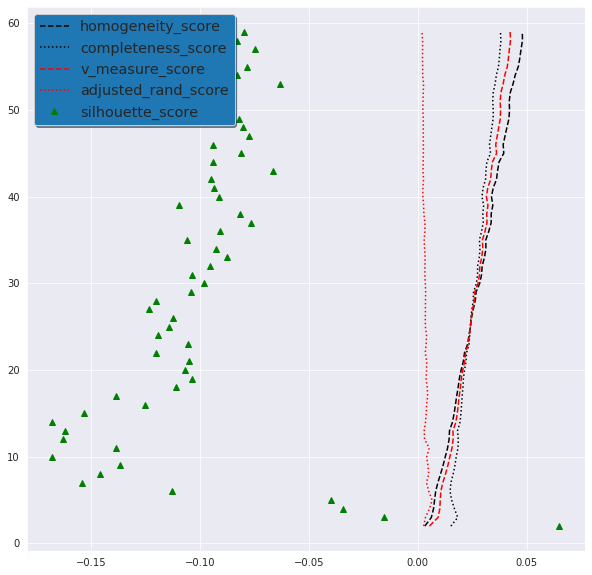

In [60]:
inertia=np.array(inertia)
c=range(2,60)
fig, ax = plt.subplots()
fig.set_size_inches(10, 10, forward=True) 
ax.plot(inertia[:, 0], c, 'k--', label='homogeneity_score')
ax.plot(inertia[:, 1], c, 'k:', label='completeness_score')
ax.plot(inertia[:, 2], c, 'r--', label='v_measure_score')
ax.plot(inertia[:, 3], c, 'r:', label='adjusted_rand_score')
ax.plot(inertia[:, 4], c, 'g^', label='silhouette_score')
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C0')
plt.show()

---

In [0]:
NUM_CLASSES = 37
cat_labels = tf.keras.utils.to_categorical(
df.id_category, num_classes=NUM_CLASSES)
#переводим классы в массив 0 и 1

In [46]:
cat_labels.shape

(197984, 37)

In [47]:
cat_labels[1]#пример

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.], dtype=float32)

In [48]:
# vocabulary
word2idx = tokenizer.word_index
idx2word = {v:k for k, v in word2idx.items()}
word2idx["PAD"] = 0
idx2word[0] = "PAD"
vocab_size = len(word2idx)
print("vocab size: {:d}".format(vocab_size))

vocab size: 82752


---
Объектное программирование нейронной сети

In [0]:
import gensim.downloader as api
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as ll
from tensorflow.keras.utils import to_categorical

In [0]:
class WideAndDeepModel(tf.keras.models.Model):
  def __init__(self, vokab=vocab_size,input_length=105,outpyt_length=10, activation="relu",kernel_size=5,drop=0.3, **kwargs):
     super().__init__(**kwargs)
     self.hidden1 = tf.keras.layers.Embedding(input_dim=vokab,output_dim=outpyt_length,input_length=input_length, trainable=True)
     self.hidden2 = tf.keras.layers.Conv1D(filters=256, kernel_size=kernel_size, activation=activation)
     self.hidden3 = tf.keras.layers.SpatialDropout1D(drop)
     self.hidden4 = tf.keras.layers.GlobalMaxPooling1D()
     self.hidden5 = tf.keras.layers.BatchNormalization()
     self.hidden6 = tf.keras.layers.Dense(256,activation=activation)
     self.output_new = tf.keras.layers.Dense(37, activation = "softmax")
  def call(self, inputs):
        input_A = inputs
        hidden1 = self.hidden1(input_A)
        hidden2 = self.hidden2(hidden1)
        hidden3 = self.hidden3(hidden2)
        hidden4 = self.hidden3(hidden3)
        hidden5 = self.hidden4(hidden4)
        hidden6 = self.hidden5(hidden5)
        output_new = self.output_new(hidden6)

        return output_new

In [0]:
model = WideAndDeepModel(activation="relu")

In [0]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(text_sequences, cat_labels, test_size=0.3)# делим еще раз нашу выборку так как она члишком большая.

In [0]:
model.compile(optimizer='adam', loss=tf.keras.losses.kld,#loss="categorical_crossentropy",
metrics=["accuracy"])

In [0]:
import datetime, os

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

callbacks_list = [
       ModelCheckpoint(
        filepath='my_model-1.h5',
        monitor='val_loss',
        save_best_only=True),
       EarlyStopping(
        patience=4
       ),
       TensorBoard(
        histogram_freq=1,  
        log_dir=logdir  
       )

]


history=model.fit(X_train_1, y_train_1,
          validation_data=(X_test_1,y_test_1), epochs=5,callbacks=callbacks_list,batch_size = 128,verbose=1);

Train on 138588 samples, validate on 59396 samples
Epoch 1/5
138588/138588 [==============================] - 12s 88us/sample - loss: 2.4833 - accuracy: 0.3671 - val_loss: 1.8518 - val_accuracy: 0.5148
Epoch 2/5
138588/138588 [==============================] - 12s 85us/sample - loss: 1.7237 - accuracy: 0.5409 - val_loss: 1.6859 - val_accuracy: 0.5487
Epoch 3/5
138588/138588 [==============================] - 12s 84us/sample - loss: 1.4471 - accuracy: 0.6010 - val_loss: 1.6831 - val_accuracy: 0.5566
Epoch 4/5
138588/138588 [==============================] - 12s 87us/sample - loss: 1.2647 - accuracy: 0.6436 - val_loss: 1.7483 - val_accuracy: 0.5508
Epoch 5/5
138588/138588 [==============================] - 13s 91us/sample - loss: 1.1286 - accuracy: 0.6771 - val_loss: 1.8399 - val_accuracy: 0.5430


In [0]:
np.mean(history.history['val_accuracy'])

0.54278743

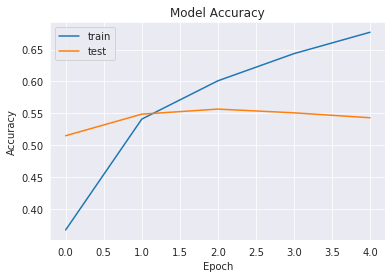

In [0]:

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
%tensorboard --logdir logs

---

---
Попытаемся использовать другой способ (например hyperopt)

In [0]:
from hyperopt import fmin, hp, tpe, STATUS_OK, space_eval, Trials
simple_space_xgb = {
   
            'optimizer': hp.choice('optimizer',['adam', 'sgd']),
            'drop': hp.quniform('drop', 0.1, 0.5, 0.1), 
            'activation': hp.choice('activation',['relu', 'selu', 'elu', 'selu']),
            'filter_one': hp.choice('filter_one', np.arange(128, 512, 128, dtype=int)), 
            'filter_two': hp.choice('filter_two', np.arange(10, 37, 1, dtype=int)),
            'counter': hp.choice('counter', np.arange(10, 100, 10, dtype=int)),
          
           
}

In [0]:
keep_trials = Trials()

In [0]:
def bild_model(X,y,params):  
  model = Sequential([
  ll.Embedding(vocab_size,
  params['counter'],
  input_length=105,
  trainable=True),
  
  ll.Conv1D(filters=params['filter_one'],
    kernel_size=5,
    activation=params['activation']),
  ll.BatchNormalization(),
  ll.SpatialDropout1D(params['drop']),
  ll.GlobalMaxPooling1D(),
  ll.BatchNormalization(),
  ll.Dense(params['filter_two'],
                kernel_initializer='uniform',
                activation=params['activation']),
  ll.Dense(37, activation = "softmax")
  ])

  model.compile(optimizer=params['optimizer'], loss='categorical_crossentropy', metrics=["accuracy"])
  history = model.fit(
        X,
        y,
        batch_size=32,
        validation_split=0.2,
        epochs = 3,
        shuffle = True,
        verbose=0)

  return np.mean(history.history['val_accuracy'])

In [0]:
def hyperopt_fn(hyper_params):
    accuracy = bild_model(X_train_1, y_train_1, hyper_params) # X,Y are globally defined!
    return -accuracy

In [0]:
%%time
opt_params = fmin(
                fn=hyperopt_fn,
                space=simple_space_xgb,
                algo=tpe.suggest,
                max_evals=30, #
                trials = keep_trials,
                verbose=0
                )


100%|██████████| 30/30 [2:00:01<00:00, 475.51s/it, best loss: -0.5580248236656189]
CPU times: user 5h 48s, sys: 14min 11s, total: 5h 15min
Wall time: 2h 1s


Попытаемся подобрать лучшие параметры при помощи RandomizedSearchCV

In [0]:
def build_model(kernel_size=5, activation='relu', drop=0.2, counter=1,learning_rate=0.001,vocab_size=vocab_size):
  model = Sequential(name="mlp")

  model.add(ll.Embedding(vocab_size,
  10,
  input_length=105,
  trainable=True))

  for i in range(counter):
    model.add(ll.Conv1D(filters=256,
    kernel_size=kernel_size,
    activation=activation))
    model.add(ll.BatchNormalization())

  model.add(ll.SpatialDropout1D(drop))
  model.add(ll.GlobalMaxPooling1D())

  model.add(ll.BatchNormalization())

  model.add(ll.Dense(256,
                kernel_initializer='uniform',
                activation=activation))


  model.add(ll.Dense(37, activation = "softmax"))

  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)
  model.compile(optimizer="adam", loss="categorical_crossentropy",
  metrics=["accuracy"])
  return model


In [0]:
param_distribs = {
    'activation': ['relu', 'selu', 'ELU', 'SELU'],
    'kernel_size':[4, 5, 6, 7],
    'drop':[0.1, 0.2, 0.3, 0.4],
    'counter':[1, 2, 3, 4],
    'learning_rate': [0.0001,0.001, 0.01],
}

In [0]:
o_model=tf.keras.wrappers.scikit_learn.KerasClassifier(build_model)

In [0]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(text_sequences, cat_labels, test_size=0.3)

In [0]:
from sklearn.model_selection import RandomizedSearchCV

In [0]:
rnd_search_cv = RandomizedSearchCV(o_model, param_distribs, n_iter=30, cv=3, verbose=1)

In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
callbacks_list = [
        ModelCheckpoint(
        filepath='my_model-1.h5',
        monitor='val_loss',
        save_best_only=True),
       EarlyStopping(
        patience=2
       )
]


rnd_search_cv.fit(X_train_1, y_train_1,
          validation_data=(X_test_1,y_test_1), epochs=10,callbacks=callbacks_list,batch_size = 128,verbose=1);

In [0]:
rnd_search_cv.best_params_

{'activation': 'relu',
 'counter': 1,
 'drop': 0.3,
 'kernel_size': 5,
 'learning_rate': 0.001}

In [0]:
rnd_search_cv.best_score_

0.5238332152366638

Мы обучили модель на основе CNN<br> 
Мы использовали 2 способа создания модели так же мы использовали подбор параметров для модели. <br>
С точностью на уровне 0.55 для 37 классов. 

 

---
Ради эксперемента обучим RNN модель.

In [0]:
X_train_1, X_test_1  = train_test_split(new_df_RNN['text'], test_size=0.90)

In [0]:
X_train_1 = X_train_1.apply(lambda x: re.sub(r'[^A-Za-z ]+','',x)) #удаляем все кроме букв английского алфавита. Иначе совсем долго ((

In [0]:
text= [x for x in X_train_1]
text=' '.join([str(elem) for elem in text]) 

In [0]:
"".join(sorted(set(text.lower())))

' abcdefghijklmnopqrstuvwxyz'

In [0]:
text[10:250]

'ani ABC Interview Was A Mess Here Are The Biggest Takeaways How separate fact opinion Giuliani wondered aloud Israeli Forces Shoot Dead Palestinians Accused Of Attempted Attacks At least Palestinians Israelis killed past weeks Pediatricians'

In [0]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)# токенизация текста
tokenizer.fit_on_texts(text)

In [0]:
tokenizer.texts_to_sequences(["dad"])

[[11, 3, 11]]

In [0]:
max_id = len(tokenizer.word_index)  #число букв
dataset_size = tokenizer.document_count  

In [0]:
max_id

27

In [0]:
dataset_size #длина

2735716

In [0]:
[encoded] = np.array(tokenizer.texts_to_sequences([text])) - 1
train_size = dataset_size * 90 // 100
dataset = tf.data.Dataset.from_tensor_slices(encoded[:train_size])

In [0]:
s=np.array(tokenizer.texts_to_sequences([text]))

In [0]:
s.shape

(1, 2718867)

In [0]:
train_size

2446980

In [0]:
n_steps = 100
window_length = n_steps + 1 
dataset = dataset.repeat().window(window_length, shift=1, drop_remainder=True)

In [0]:
dataset = dataset.flat_map(lambda window: window.batch(window_length))

In [0]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size)
dataset = dataset.map(lambda windows: (windows[:, :-1], windows[:, 1:]))

In [0]:
dataset = dataset.map(
    lambda X_batch, Y_batch: (tf.one_hot(X_batch, depth=max_id), Y_batch))

In [0]:
dataset = dataset.prefetch(1)

In [0]:
for X_batch, Y_batch in dataset.take(1):
    print(X_batch.shape, Y_batch.shape)

(32, 100, 27) (32, 100)


In [0]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard
callbacks_list = [
        ModelCheckpoint(
        filepath='my_model-1.h5',
        monitor='val_loss',
        save_best_only=False),
       EarlyStopping(
        patience=3
       )
]



model = tf.keras.models.Sequential([
    tf.keras.layers.GRU(128, return_sequences=True, input_shape=[None, max_id],
                     # no dropout in stateful RNN (https://github.com/ageron/handson-ml2/issues/32)
                     dropout=0.2, recurrent_dropout=0.2,
                     ),
    tf.keras.layers.GRU(128, return_sequences=True,
                     dropout=0.2, recurrent_dropout=0.2
                    ),
    tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(max_id,
                                                    activation="softmax"))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="adam")
history = model.fit(dataset, steps_per_epoch=train_size // batch_size,
                    epochs=10,callbacks=callbacks_list)

Train for 76839 steps
Epoch 1/10
 1392/76839 [..............................] - ETA: 1:42:26 - loss: 2.3576

---

---
Ради эксперемента пробуем обучить классическую модель

##XGBClassifier

In [0]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import cross_val_score
from xgboost import XGBClassifier
 
from hyperopt import hp, tpe
from hyperopt.fmin import fmin

In [0]:
def hyperopt_xgb_score(params):
    clf = XGBClassifier(**params)
    # усреднение по 3ем фолдам, для уменьшения влияния стахостичности
    # для ускорения можно использовать train_test_split один раз
    current_score = cross_val_score(clf, X_train,y_train, cv=3).mean()
    print(current_score, params)
    return -current_score
    if acc < min_acc:
         clf.sa
 
simple_space_xgb = {
            'n_estimators': hp.choice('n_estimators', range(100, 1000)),
            'eta': hp.quniform('eta', 0.025, 0.5, 0.025),
            'max_features': hp.quniform('max_features', 1,150,5),
            'max_depth':  hp.choice('max_depth', np.arange(1, 20, dtype=int)),
            'min_child_weight': hp.quniform('min_child_weight', 1, 6, 1),
            'max_delta_step': hp.quniform('max_delta_step', 1, 10, 1),
            'subsample': hp.quniform('subsample', 0, 1, 0.1)
}

In [0]:
best = fmin(fn=hyperopt_xgb_score, space=simple_space_xgb, algo=tpe.suggest, max_evals=10)
print('best:', best)

In [0]:
#0.3064953567196671
#{'eta': 0.225, 'max_delta_step': 5.0, 'max_depth': 3, 'max_features': 30.0, 'min_child_weight': 2.0, 'n_estimators': 950, 'subsample': 1.0}

##svm

In [0]:
# C
C = [.0001, .001, .01]

# gamma
gamma = [.0001, .001, .01, .1, 1, 10, 100]

# degree
degree = [1, 2, 3, 4, 5]

# kernel
kernel = ['linear', 'rbf', 'poly']

# probability
probability = [True]

# Созданим рандом грид
random_grid = {'C': C,
              'kernel': kernel,
              'gamma': gamma,
              'degree': degree,
              'probability': probability
             }

pprint(random_grid)

{'C': [0.0001, 0.001, 0.01],
 'degree': [1, 2, 3, 4, 5],
 'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
 'kernel': ['linear', 'rbf', 'poly'],
 'probability': [True]}


In [0]:
svc = svm.SVC(random_state=8)

random_search = RandomizedSearchCV(estimator=svc,
                                   param_distributions=random_grid,
                                   n_iter=20,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

random_search.fit(X_train,y_train)

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 23.0min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=8,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=20, n_jobs=None,
                   param_distributions={'C': [0.0001, 0.001, 0.01],
                                        'degree': [1, 2, 3, 4, 5],
                                        'gamma': [0.0001, 0.001, 0.01, 0.1, 1,
                                                  10, 100],
                                        'kernel': ['linear', 'rbf', 'poly'],
                                        'probability': [True]},
                   pre_dispatch='2*n_jobs', random_s

In [0]:
print("The best hyperparameters from Random Search are:")
print(random_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search.best_score_)

The best hyperparameters from Random Search are:
{'probability': True, 'kernel': 'poly', 'gamma': 10, 'degree': 4, 'C': 0.01}

The mean accuracy of a model with these hyperparameters is:
0.1672909452206209


##RandomForestClassifier
---

In [0]:
# n_estimators
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 5)]

# max_features
max_features = ['auto', 'sqrt']

# max_depth
max_depth = [int(x) for x in np.linspace(20, 100, num = 5)]
max_depth.append(None)

# min_samples_split
min_samples_split = [2, 5, 10]

# min_samples_leaf
min_samples_leaf = [1, 2, 4]

# bootstrap
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [20, 40, 60, 80, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000]}


In [0]:
from sklearn.ensemble import RandomForestClassifier
#RandomForestClassifier
rfc = RandomForestClassifier(random_state=8)

#RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rfc,
                                   param_distributions=random_grid,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit 
random_search.fit(X_train,y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 150 out of 150 | elapsed: 196.9min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [0]:
max_features = ['sqrt']
min_samples_leaf = [4, 3, 5]
min_samples_split = [8, 10, 12]
n_estimators = [1000,1200]
max_features = ['sqrt']
max_depth=[None]
bootstrap = [True]
param_grid = {
    'bootstrap': bootstrap,
    'max_depth': max_depth,
    'max_features': max_features,
    'min_samples_leaf': min_samples_leaf,
    'min_samples_split': min_samples_split,
    'n_estimators': n_estimators
}

In [0]:
# Create a base model
rfc = RandomForestClassifier(random_state=8)
from sklearn.model_selection import ShuffleSplit
# Manually create the splits in CV in order to be able to fix a random_state (GridSearchCV doesn't have that argument)
cv_sets = ShuffleSplit(n_splits = 3, test_size = .33, random_state = 8)
from sklearn.model_selection import GridSearchCV
# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rfc, 
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=cv_sets,
                           verbose=1)

# Fit the grid search to the data
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 18 candidates, totalling 54 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 28.9min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=8, test_size=0.33, train_size=None),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_sampl...
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=8,
                                  

In [0]:
print("The best hyperparameters from Grid Search are:")
print(grid_search.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(grid_search.best_score_)

The best hyperparameters from Grid Search are:
{'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 1200}

The mean accuracy of a model with these hyperparameters is:
0.3448627691051933


In [0]:
best_rfc = grid_search.best_estimator_

In [0]:
best_rfc.score(X_test,y_test)
#точность предсказания на тестовой выборке которая в 20 раз больше тренировочной. 

0.3581678496424489

---

Word2Vec

In [0]:
from gensim.models import Word2Vec

In [0]:
import tensorflow.keras.preprocessing.text as tx
df['new_text'] = df.text.apply(lambda i: i.split())


In [0]:
model = Word2Vec(df['new_text'], min_count=1,size= 50)

In [0]:
model.most_similar('blasts')[:10]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('abbott', 0.9836699962615967),
 ('accuses', 0.982663094997406),
 ('lt', 0.9823393821716309),
 ('rex', 0.9786766767501831),
 ('timothy', 0.9773693084716797),
 ('compares', 0.9771894216537476),
 ('stormy', 0.9770557284355164),
 ('quits', 0.9763152003288269),
 ('mcauliffe', 0.975439190864563),
 ('hogan', 0.9746733903884888)]

In [0]:
words_model = model[model.wv.vocab]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [0]:
len(df)

197984

##Выводы
1.	Классификация неразмеченных данных довольно сложная задача. Метрики качества не дают нам гарантии того, что мы разметили данные хорошо. Необходимо визуализировать по возможности, классы, которые мы определяем. Для классификации хорошо подходят методы типа DBSCAN.
2.	Классификация текстовой информации опять же возможна на основании методов типа DBSCAN где мы хотим выделить похожие текста. Однако степень похожести решать нужно нам.
3.	Не существует метрики, которая однозначно позволила бы определить число классов.
4.	Мы разобрали 3 основных способа при помощи которых могут быть созданы нейронные сети. Мы разобрали так же способы подбора параметров на основе случайного поиска а так же градиентного поиска.
5. Часть кода стоило бы оформить функциями и / или отдельными классами. В следующий раз постораюсь сделать. 



In [0]:
!pip freeze > requirements.txt

Модели не сохранены так как в этом нет смысла на данный момент. 